In [ ]:
#from langchain_community.embeddings import HuggingFaceEmbeddings
from tqdm import tqdm
import numpy as np
import networkx as nx
#from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

from utils import *

In [3]:
embedding_model = HuggingFaceEmbeddings(
    model_name="thenlper/gte-small",
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

NameError: name 'HuggingFaceEmbeddings' is not defined

In [ ]:
course_numbers = [
    1043, 1045, 1046, 1047, 1048, 1049, 1050, 1054, 1055, 1056, 
    1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 
    1067, 1068, 1069, 1221
]

courses = []
course_embeddings = []

for n in tqdm(course_numbers):
    new_course = Course(f'https://certification.adobe.com/courses/{n}')
    courses.append(new_course)
    # course_embeddings.append(new_course.get_embedding(embedding_model))

print(len(courses))

100%|██████████| 24/24 [00:11<00:00,  2.14it/s]

24


In [ ]:
certificate_htmls_location = 'certificate_htmls'
certificates = []
certificate_embeddings = []

for html in tqdm(os.listdir(certificate_htmls_location)):
    certificate = Certificate(f'{certificate_htmls_location}/{html}')
    certificates.append(certificate)
    # certificate_embeddings.append(certificate.get_embedding(embedding_model))

100%|██████████| 54/54 [00:02<00:00, 24.86it/s]


In [ ]:
# all_embeddings = np.concatenate((course_embeddings, certificate_embeddings), axis=0).reshape(len(course_embeddings) + len(certificate_embeddings), 2 * 384)

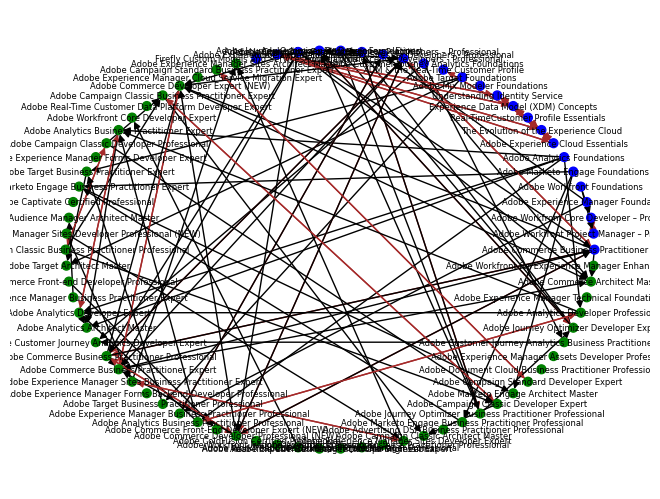

In [ ]:
G = nx.DiGraph()

# similarity_matrix = cosine_similarity(all_embeddings)

sources = courses + certificates
node_colors = []
for src in sources:
    G.add_node(src)
    if type(src) == Course:
        node_colors.append('blue')
    else:
        node_colors.append('green')

levels = ['Foundations', 'Professional', 'Expert', 'Master']
threshold = 0.9

for i, src1 in enumerate(sources):
    for j, src2 in enumerate(sources):
        if i == j:
            continue
        if src1.is_prereq_to(src2):
            G.add_edge(src1, src2, color='black')
        elif src1.has_same(src2, 'category'):
            G.add_edge(src1, src2, color='brown')
        # elif src1.is_same_role_as(src2):
        #     G.add_edge(src1, src2, color='purple')
        
        # elif src1.category != src2.category and similarity_matrix[i, j] > threshold:
        #     G.add_edge(src1, src2, color='red')

colors = [G[u][v]['color'] for u,v in G.edges()]

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_size=6, edge_color=colors, node_color=node_colors, node_size=40)

In [ ]:
certificates[-1].category

'Adobe Workfront Project'